## Transcripts Analysis
### individual transcripts compared to each other/the whole

Eileen McGivney  
Science identity study  
Data: interviews with 15 7th graders  
Preprocessing: /Volumes/GoogleDrive/My Drive/Spring 2019/S435/GitHub/final-project-EileenMcGivney/Preprocessing-McGivney.ipynb  

Research Question: Can we identify student profiles related to their science identity and interest through natural language processing?

Analysis: Bag of words
* What words might characterize the different transcripts?
* How do the individual trnascript descriptions compare to an anlysis of all the transcripts together?
* How would these descriptions compare to the clustering/vector space models I did on text segments?


In [67]:
## Setup
import pickle
import itertools

from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from collections import defaultdict

## Setup
import os
import re
import glob
import math
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
#nltk.download('punkt')
from collections import Counter

from collections import defaultdict
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import NMF

%cd '/Volumes/GoogleDrive/My Drive/Spring 2019/S435/GitHub/final-project-EileenMcGivney'


/Volumes/GoogleDrive/My Drive/Spring 2019/S435/GitHub/final-project-EileenMcGivney


In [64]:
### Load in the cleaned transcripts
import pickle
docs = []
for i in range (15):
    with open('./cleandocs/doc'+str(i)+'.txt', 'rb') as fp:
        docs.append(pickle.load(fp))

In [65]:
### Flatten into one document too
alldocs = [y for x in docs for y in x]
print(alldocs[500:600])

['favorite', 'subject', 'fun', 'usually', 'talk', 'water', 'animals', 'much', 'would', 'moved', 'onto', 'part', 'liked', 'usually', 'things', 'rock', 'science', 'unit', 'systems', 'energy', 'light', 'bulbs', 'things', 'living', 'things', 'electricity', 'think', 'fun', 'experience', 'people', 'already', 'knew', 'think', 'they', 'still', 'liked', 'they', 'saw', 'different', 'way', 'think', 'would', 'fun', 'people', 'people', 'try', 'think', 'thing', 'might', 'people', 'didn', 'try', 'found', 'boring', 'know', 'people', 'know', 'they', 'would', 'much', 'people', 'said', 'they', 'found', 'boring', 'didn', 'think', 'boring', 'know', 'haven', 'talked', 'many', 'people', 'got', 'talk', 'people', 'weren', 'wanted', 'know', 'they', 'know', 'many', 'people', 'found', 'boring', 'maybe', 'thing', 'thought', 'pretty', 'fun', 'different', 'way', 'learn', 'also', 'hands', 'without', 'actually', 'going', 'real', 'world']


In [70]:
### Load in vector dataframes
# Regular vectors:
dfall = pd.read_csv('./dataframes/transcripts_all.csv', index_col=0)

# Deviation vectors:
dfall_dev = pd.read_csv('./dataframes/transcripts_all.csv', index_col=0)

## Load the vocabulary
%store -r vocabulary
print(len(vocabulary))

992


## Cluster on the transcripts?

**KMeans: inertia and KMeans clustering**

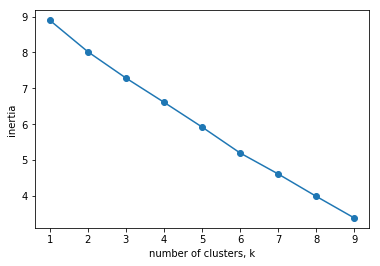

In [71]:
# Inertia values and plot
ks = list(range(1, 10))
inertias = []

for k in ks:
    
    # Create a KMeans instance with k clusters: model
    kmeans = KMeans(n_clusters=k, max_iter=1000)
    
    # Fit model to samples
    kmeans.fit(dfall_dev.values)
    
    # Append the inertia to the list of inertias
    inertias.append(kmeans.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [72]:
## k=5 Kmeans clustering:  print the first 10 words that are the most associated with each cluster centroids

kmeans_obj = KMeans(n_clusters=5, max_iter=1000).fit(dfall_dev.values)

n_words = 10
top_words = collections.defaultdict(lambda: [])

# iterate through each cluster
for n in range(kmeans_obj.n_clusters):

    print('CLUSTER ' + str(n+1) + ': ', end='')

    # get the cluster centers
    arr = kmeans_obj.cluster_centers_[n]

    # sorts the array and keep the last n words
    indices = arr.argsort()[-n_words:]

    # add the words to the list of words
    for i in indices:
        print(vocabulary[i], end=', ')
        top_words[n].append(vocabulary[i])
        
    print('')

CLUSTER 1: something, didn, science, would, my, different, know, things, think, they, 
CLUSTER 2: things, something, people, instead, collecting, experiments, figure, could, data, know, 
CLUSTER 3: didn, trying, try, favorite, science, data, different, guess, tries, my, 
CLUSTER 4: day, science, evidence, go, could, going, thought, fun, try, they, 
CLUSTER 5: science, deeply, virtual, notes, think, experiments, take, different, world, they, 


In [85]:
## k=3 Kmeans clustering:  print the first 10 words that are the most associated with each cluster centroids

kmeans_obj = KMeans(n_clusters=3, max_iter=1000).fit(dfall_dev.values)

n_words = 10
top_words = collections.defaultdict(lambda: [])

# iterate through each cluster
for n in range(kmeans_obj.n_clusters):

    print('CLUSTER ' + str(n+1) + ': ', end='')

    # get the cluster centers
    arr = kmeans_obj.cluster_centers_[n]

    # sorts the array and keep the last n words
    indices = arr.argsort()[-n_words:]

    # add the words to the list of words
    for i in indices:
        print(vocabulary[i], end=', ')
        top_words[n].append(vocabulary[i])
        
    print('')

CLUSTER 1: they, things, scientists, different, want, thought, find, would, learn, think, 
CLUSTER 2: teacher, category, care, list, campus, talking, talks, calendar, tables, lots, 
CLUSTER 3: notebook, number, osd, overall, overseas, oxygen, partner, partners, meant, yet, 


**Hierarchical clustering**

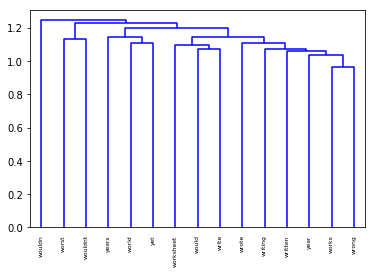

In [74]:
## Plot a dendrogram

# Calculate the linkage: mergings
mergings = linkage(dfall_dev.values, method='complete', )

# Plot the dendrogram
dendrogram(mergings,
           labels=dfall_dev.columns,
           leaf_rotation=90,
           leaf_font_size=6,
)
plt.show()

In [76]:
## Using agglomerative clustering: 10 clusters
ward = AgglomerativeClustering(n_clusters=3, linkage='ward').fit(dfall_dev.values)
label = ward.labels_

print("Number of points: %i" % label.size)

clf = NearestCentroid()
clf.fit(dfall_dev.values, label)

print(clf.centroids_.shape)

Number of points: 15
(3, 992)


In [77]:
#print the top 10 words for each cluster centroid
def visualize_clusters(df, n_clusters, centroids, n_words=10, printed=True):   
    # try to get the most informative words of each cluster
    words = {}
    vocabulary = df.columns
    for n in range(n_clusters):
        words[n] = []
        if printed: print('CLUSTER ' + str(n+1) + ': ', end='')
        arr = centroids[n]
        indices = arr.argsort()[-n_words:]
        for i in indices:
            if printed: print(vocabulary[i], end=', '),
            words[n].append(vocabulary[i])
        print('')
    return words

top_words = visualize_clusters(dfall_dev, clf.centroids_.shape[0], clf.centroids_)

CLUSTER 1: science, see, something, know, could, would, different, things, think, they, 
CLUSTER 2: think, thought, didn, good, know, guess, my, try, science, they, 
CLUSTER 3: things, something, people, instead, collecting, experiments, figure, could, data, know, 


**TSNE**

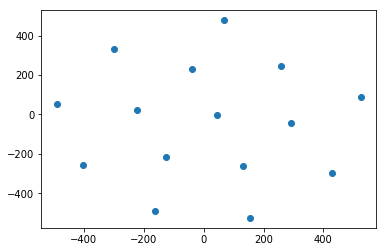

In [78]:

# Create a TSNE instance: model
model = TSNE(learning_rate=200)

# Apply fit_transform to samples: tsne_features
tsne_features = model.fit_transform(dfall_dev.values)

# Select the 0th feature: xs
xs = tsne_features[:,0]

# Select the 1st feature: ys
ys = tsne_features[:,1]

# Scatter plot
plt.scatter(xs,ys)
plt.show()

**DBSCAN**

In [270]:
# #apply DBScan 
# dbscan = DBSCAN(eps=5, min_samples=5).fit(dfall_dev.values)

# labels = dbscan.labels_

# print("Number of points: %i" % labels.size)

# #find the cluster centroid (using the code from above)
# clf = NearestCentroid()
# clf.fit(dfall_dev.values, labels)

# print(clf.centroids_.shape)

In [271]:
# top_words = visualize_clusters(dfall_dev, clf.centroids_.shape[0], clf.centroids_)

NMF

In [83]:
# Transform data so not negative:
scaler = MinMaxScaler()
dfall_dev[dfall_dev.columns] = scaler.fit_transform(dfall_dev[dfall_dev.columns])

# Create an NMF instance: model
model = NMF(n_components=3)

# Fit the model to articles
model.fit(dfall_dev.values)

# Transform the articles: nmf_features
nmf_features = model.transform(dfall_dev.values)

# Print the NMF features
print(nmf_features[:3])

[[1.53730197 0.01875992 0.        ]
 [1.47720108 0.         0.        ]
 [1.06680576 0.13512873 0.        ]]


In [84]:
import pandas as pd

# Create a DataFrame: components_df
components_dfall_dev = pd.DataFrame(model.components_, columns=dfall_dev.columns)

for i in range(3):

    # Select row : component
    component = components_dfall_dev.iloc[i,:]

    # Print result of nlargest
    print(component.nlargest(n=10), '\n')

find         0.514108
would        0.508531
think        0.507468
learn        0.480666
see          0.463434
ecoxpt       0.460142
me           0.452397
different    0.451585
water        0.430234
they         0.429568
Name: 0, dtype: float64 

environment    0.274650
law            0.268749
algae          0.268009
work           0.267592
friend         0.267282
hurting        0.267282
ecosystem      0.265683
answers        0.264859
population     0.264064
partner        0.263757
Name: 1, dtype: float64 

feel          0.291452
deep          0.286061
wanted        0.278722
seems         0.269640
definitely    0.269544
always        0.268801
aren          0.267301
interested    0.264874
helped        0.264609
systems       0.262966
Name: 2, dtype: float64 



**Using Gensim to do a bag of words**

In [51]:


# Create a Dictionary from the transcripts
dictionary = Dictionary(docs)

# Select the id for "computer": computer_id
science_id = dictionary.token2id.get("science")

# Use with the dictionary to print the word
print(dictionary.get(science_id))

# Create a MmCorpus: corpus
corpus = [dictionary.doc2bow(doc) for doc in docs]

# Print the first 10 word ids with their frequency counts from the fifth transcript
print(corpus[4][:10])



science
[(0, 1), (2, 1), (6, 3), (8, 1), (9, 1), (11, 1), (12, 8), (16, 2), (17, 3), (27, 2)]


In [52]:
## Test out bag of words on one transcript 

# Save the fifth transcript: tran
tran = corpus[4]

# Sort the doc for frequency: bow_tran
bow_tran = sorted(tran, key=lambda w: w[1], reverse=True)
print(bow_tran)

# Print the top 5 words of the document alongside the count
for word_id, word_count in bow_tran[:5]:
    print(dictionary.get(word_id), word_count)

[(154, 18), (212, 18), (179, 14), (34, 10), (137, 10), (494, 10), (64, 9), (152, 9), (12, 8), (60, 8), (28, 7), (101, 7), (142, 7), (164, 7), (578, 7), (57, 6), (160, 6), (196, 6), (201, 6), (410, 6), (421, 6), (446, 6), (69, 5), (71, 5), (111, 5), (112, 5), (117, 5), (150, 5), (182, 5), (248, 5), (261, 5), (310, 5), (423, 5), (534, 5), (35, 4), (40, 4), (62, 4), (88, 4), (124, 4), (181, 4), (390, 4), (569, 4), (583, 4), (6, 3), (17, 3), (33, 3), (50, 3), (65, 3), (66, 3), (87, 3), (148, 3), (178, 3), (194, 3), (430, 3), (550, 3), (579, 3), (16, 2), (27, 2), (48, 2), (55, 2), (106, 2), (109, 2), (110, 2), (114, 2), (121, 2), (126, 2), (128, 2), (131, 2), (134, 2), (195, 2), (202, 2), (213, 2), (215, 2), (221, 2), (236, 2), (280, 2), (323, 2), (354, 2), (436, 2), (460, 2), (471, 2), (477, 2), (523, 2), (528, 2), (533, 2), (537, 2), (539, 2), (547, 2), (548, 2), (549, 2), (552, 2), (554, 2), (557, 2), (559, 2), (560, 2), (564, 2), (571, 2), (572, 2), (581, 2), (584, 2), (587, 2), (0, 1),

In [53]:
### create dictionary for all transcripts:

# Create the defaultdict: total_word_count
total_word_count = defaultdict(int)
for word_id, word_count in itertools.chain.from_iterable(corpus):
    total_word_count[word_id] += word_count

# Create a sorted list from the defaultdict: sorted_word_count
sorted_word_count = sorted(total_word_count.items(), key=lambda w: w[1], reverse=True) 

# Print the top 5 words across all documents alongside the count
for word_id, word_count in sorted_word_count[:20]:
    print(dictionary.get(word_id), word_count)

really 138
they 136
things 112
think 105
different 73
know 67
science 61
would 54
my 49
could 47
see 44
didn 43
fish 43
fun 40
go 39
stuff 39
people 38
something 37
experiments 33
look 32


In [54]:
### top words for each transcript

# for i,doc in enumerate(corpus):
#     tran[i] = sorted(doc, key=lambda w: w[1], reverse=True)

# for i in range(14):
#     print('Transcript '+str(i)+': ')
#     for word_id, word_count in tran[i][:5]:
#         print(dictionary.get(word_id), word_count)


**tf-idf model**

In [55]:
# Create a new TfidfModel using the corpus: tfidf
tfidf = TfidfModel(corpus)

# Calculate the tfidf weights of the fifth transcript
tfidf_weights = tfidf[tran]

# Print the first five weights
print(tfidf_weights[:5])

# Sort the weights from highest to lowest: sorted_tfidf_weights
sorted_tfidf_weights = sorted(tfidf_weights, key=lambda w: w[1], reverse=True)

# Print the top 5 weighted words
for term_id, weight in sorted_tfidf_weights[:5]:
    print(dictionary.get(term_id), weight)

[(0, 0.009765617121385553), (2, 0.025268429892106842), (6, 0.0437102267088253), (8, 0.012017313152479052), (9, 0.03076814024637398)]
teacher 0.2696368264221424
give 0.25885331685681207
put 0.2526842989210684
year 0.2526842989210684
topic 0.20708265348544966


In [57]:
### get a weighted dictionary for every transcript
# Calculate the tfidf weights of the fifth transcript

tfidf = TfidfModel(corpus)
for i,tran in enumerate(corpus):
    tfidf_weights = tfidf[tran]
    # Sort the weights from highest to lowest
    sorted_tfidf_weights[i] = sorted(tfidf_weights, key=lambda w: w[1], reverse=True)
    
# # Print the top 5 weighted words for each:
# for i in range(15):
#     print('Transcript '+str(i)+': ')
#     for term_id, weight in sorted_tfidf_weights[i][:5]:
#         print(dictionary.get(term_id), "{:.2f}".format(weight))
        
        
# Print the top 5 weighted words for each:
for i in range(15):
    print('Transcript '+str(i)+': ')
    for term_id, weight in sorted_tfidf_weights[i][:10]:
        print(dictionary.get(term_id))

Transcript 0: 
books
inside
known
even
affected
certain
parts
pond
boring
graphs
Transcript 1: 
problem
jobs
lead
noticed
ways
fertilizer
since
solving
bigger
compared
Transcript 2: 
died
general
fish
guess
biology
chemist
investigate
solutions
finding
dying
Transcript 3: 
tries
spectrum
speed
favorite
light
enjoy
guess
data
exactly
answering
Transcript 4: 
teacher
give
put
year
topic
graphs
thoughts
saw
easy
map
Transcript 5: 
collecting
data
figure
assigned
basically
events
getting
historical
lets
prefer
Transcript 6: 
fits
inference
choose
hypothesis
criminal
evidence
outdoors
going
attorney
charge
Transcript 7: 
dead
matter
hurt
supposed
law
partner
work
lawyer
let
access
Transcript 8: 
bees
interested
definitely
ecology
measurements
playing
spend
kinds
questions
seems
Transcript 9: 
position
felt
effort
enjoyed
exciting
forms
labs
ecosystems
future
video
Transcript 10: 
living
sort
nonliving
variables
attention
hadn
tested
cell
check
connect
Transcript 11: 
problems
torture
tell
f

In [60]:
# ### count vectorizer
# from sklearn.feature_extraction.text import CountVectorizer
# count_vectorizer = CountVectorizer()
# count = count_vectorizer.fit_transform(alldocs)
# print(count_vectorizer.get_feature_names()[:10])

['ability', 'able', 'access', 'accurate', 'accused', 'across', 'actually', 'add', 'added', 'adult']


In [62]:
# # Import TfidfVectorizer
# from sklearn.feature_extraction.text import TfidfVectorizer

# # Initialize a TfidfVectorizer object: tfidf_vectorizer
# tfidf_vectorizer = TfidfVectorizer(max_df=0.7)

# # Transform the training data: tfidf_train 
# tfidf = tfidf_vectorizer.fit_transform(alldocs)

# # Print the first 10 features
# print(tfidf_vectorizer.get_feature_names()[:10])

# # Print the first 5 vectors of the tfidf data
# print(tfidf[:5])

['ability', 'able', 'access', 'accurate', 'accused', 'across', 'actually', 'add', 'added', 'adult']
  (0, 876)	1.0
  (1, 961)	1.0
  (2, 871)	1.0
  (3, 690)	1.0
  (4, 356)	1.0
